In [51]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras import Model
from keras import Input
from keras.utils import plot_model
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import backend as K

from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio
import os

%matplotlib inline

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
imgloc_train = []
label_train = []

imgloc_val = []
label_val = []

for dirname, _, filenames in os.walk('..\Train\Adults'):
    for filename in filenames[:-50]:
        imgloc_train.append((os.path.join(dirname, filename)))
        label_train.append(0)
    for filename in filenames[-50:]:
        imgloc_val.append((os.path.join(dirname, filename)))
        label_val.append(0)
        
for dirname, _, filenames in os.walk('..\Train\Teenagers'):
    for filename in filenames[:-50]:
        imgloc_train.append((os.path.join(dirname, filename)))
        label_train.append(1)
    for filename in filenames[-50:]:
        imgloc_val.append((os.path.join(dirname, filename)))
        label_val.append(1)
        
for dirname, _, filenames in os.walk('..\Train\Toddler'):
    for filename in filenames[:-50]:
        imgloc_train.append((os.path.join(dirname, filename)))
        label_train.append(2)
    for filename in filenames[-50:]:
        imgloc_val.append((os.path.join(dirname, filename)))
        label_val.append(2)

In [3]:
img_train = []
img_val = []

for i in range(0, len(imgloc_train)):
    img1 = cv2.imread(imgloc_train[i],1)
    img2 = np.array(img1)
    img2 = cv2.resize(img2,(128,128))
    img_train.append(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
    
for i in range(0, len(imgloc_val)):
    img1 = cv2.imread(imgloc_val[i],1)
    img2 = np.array(img1)
    img2 = cv2.resize(img2,(128,128))
    img_val.append(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))

In [4]:
img_train = np.array(img_train)
label_train = np.array(label_train).reshape(-1,1)

img_val = np.array(img_val)
label_val = np.array(label_val).reshape(-1,1)

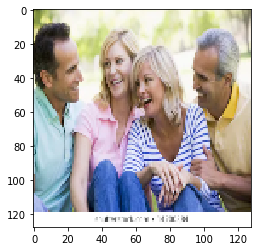

In [5]:
i = 5
plt.imshow(img_train[i])
plt.imshow(img_val[i])

In [6]:
img_train.shape

(2439, 128, 128, 3)

In [22]:
x_train = img_train/255
x_val = img_val/255

In [23]:
enc_y = OneHotEncoder(handle_unknown='ignore')
enc_y.fit(label_train)
y_train = enc_y.transform(label_train).toarray()
y_val = enc_y.transform(label_val).toarray()

In [24]:
x_train.shape

(2439, 128, 128, 3)

In [25]:
y_train.shape

(2439, 3)

In [80]:
reg = l2(1e-3)

model = Sequential()
model.add(Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', input_shape = x_train[0].shape,
                 kernel_regularizer = reg))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', kernel_regularizer = reg))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(32, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', kernel_regularizer = reg))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu', kernel_regularizer = reg))
model.add(Dense(256, activation = 'relu', kernel_regularizer = reg))
model.add(Dense(3, activation = 'softmax', kernel_regularizer = reg))

# model.load_weights('LeNet.h5')

In [81]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 124, 124, 6)       456       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 62, 62, 6)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 58, 58, 16)        2416      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 25, 25, 32)        12832     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)             

In [82]:
adam = Adam(learning_rate = 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['categorical_accuracy'])

In [83]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('LeNet-Reg.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callbacks = [es, mc]

history = model.fit(
    x = x_train,
    y = y_train,
    epochs=20, batch_size=32,
    validation_data = (x_val,y_val),
    verbose = 1, callbacks = callbacks)

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 2.9396 - categorical_accuracy: 0.3649
Epoch 00001: val_loss improved from inf to 2.64983, saving model to LeNet-Reg.h5
77/77 [==============================] - 36s 464ms/step - loss: 2.9396 - categorical_accuracy: 0.3649 - val_loss: 2.6498 - val_categorical_accuracy: 0.4733
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 2.4342 - categorical_accuracy: 0.4350
Epoch 00002: val_loss improved from 2.64983 to 2.26290, saving model to LeNet-Reg.h5
77/77 [==============================] - 37s 486ms/step - loss: 2.4342 - categorical_accuracy: 0.4350 - val_loss: 2.2629 - val_categorical_accuracy: 0.4600
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 2.0903 - categorical_accuracy: 0.4678
Epoch 00003: val_loss improved from 2.26290 to 1.97864, saving model to LeNet-Reg.h5
77/77 [==============================] - 39s 511ms/step - loss: 2.0903 - categorical_accuracy: 0.4678 - val_loss: 1.978

In [84]:
model = load_model('LeNet-Reg.h5')

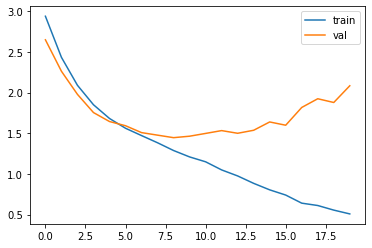

In [85]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

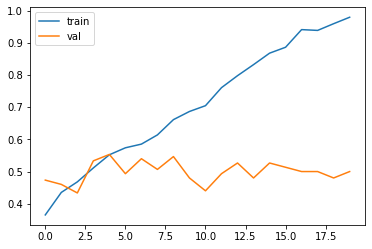

In [95]:
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [88]:
#loss 0.92
#acc 0.57
model.evaluate(x_val,y_val)

5/5 [==============================] - 0s 99ms/step - loss: 1.4462 - categorical_accuracy: 0.5467


[1.4461541175842285, 0.54666668176651]

In [89]:
ymodel = model.predict(x_val)
ymodel = enc_y.inverse_transform(ymodel)

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

In [91]:
confusion_matrix(label_val,ymodel)

array([[22, 21,  7],
       [16, 26,  8],
       [ 9,  7, 34]], dtype=int64)

In [92]:
f1_score(label_val,ymodel,average='weighted')

0.5468256447637891

In [93]:
precision_recall_fscore_support(label_val,ymodel)

(array([0.46808511, 0.48148148, 0.69387755]),
 array([0.44, 0.52, 0.68]),
 array([0.45360825, 0.5       , 0.68686869]),
 array([50, 50, 50], dtype=int64))